# Solar Orbiter
This example demonstrates a ballistic model inspired by the solar orbiter mission.

In [1]:
# Pykep imports
from pykep.trajopt import mga_1dsm, launchers
from pykep.planet import jpl_lp
from pykep import epoch
from pykep.core import lambert_problem, propagate_lagrangian, fb_prop
from pykep import DAY2SEC, DAY2YEAR, AU, RAD2DEG, ic2par
from pykep.trajopt.gym._solar_orbiter import _solar_orbiter_udp

# Other imports
import numpy as np
from numpy.linalg import norm
from numpy import sign
from math import acos, asin, cos, exp, log, pi, sin
import matplotlib.pyplot as plt
from copy import deepcopy
import pygmo
import time

In [2]:
#%matplotlib notebook

In [3]:
# define search window
tmin = epoch(time.time() / (24*3600) - 30*365 -7 + 2/24 - 2*365)
tmax = epoch(time.time() / (24*3600) - 30*365 -7 + 2/24 + 2*365)

In [4]:
solar_orbiter = _solar_orbiter_udp([tmin, tmax])

In [5]:
# Include delta v, mass and sun distance constraints
prob = pygmo.unconstrain(pygmo.problem(solar_orbiter),method="weighted",weights=[1.0, 10.0, 100, 100])

In [6]:
# define problem and algorithm
pop = pygmo.population(prob=prob, size=20)
alg = pygmo.algorithm(pygmo.sade(memory=True,gen=1))

In [7]:
# run evolution
for i in range(3000):
    pop = alg.evolve(pop)
    print(i, pop.champion_f, solar_orbiter.fitness(pop.champion_x))

0 [29166.27985202] [2.310130589471986, 11164.9697214348, 1799.9, -0.14777803492941616, -0.19999999999999996]
1 [25515.88865574] [2.363506393397893, 25280.126852570218, 23.339829677464877, -0.28309223024514407, -0.19999999999999996]
2 [25515.88865574] [2.363506393397893, 25280.126852570218, 23.339829677464877, -0.28309223024514407, -0.19999999999999996]
3 [25515.88865574] [2.363506393397893, 25280.126852570218, 23.339829677464877, -0.28309223024514407, -0.19999999999999996]
4 [25515.88865574] [2.363506393397893, 25280.126852570218, 23.339829677464877, -0.28309223024514407, -0.19999999999999996]
5 [25515.88540725] [2.360257908662506, 25280.126852570218, 23.339829677464877, -0.2826858987468306, -0.19999999999999996]
6 [18817.88743678] [2.0025242996020216, 18576.696882163975, 23.339829677464877, 0.05789733537304387, -0.19999999999999996]
7 [18817.88743678] [2.0025242996020216, 18576.696882163975, 23.339829677464877, 0.05789733537304387, -0.19999999999999996]
8 [17115.88088759] [1.967327514

70 [4615.00586009] [2.2592036649427105, 4612.746656427586, -55.55384884634759, -0.09501302219502389, -0.19999999999999996]
71 [4615.00586009] [2.2592036649427105, 4612.746656427586, -55.55384884634759, -0.09501302219502389, -0.19999999999999996]
72 [4615.00586009] [2.2592036649427105, 4612.746656427586, -55.55384884634759, -0.09501302219502389, -0.19999999999999996]
73 [4615.00586009] [2.2592036649427105, 4612.746656427586, -55.55384884634759, -0.09501302219502389, -0.19999999999999996]
74 [4615.00586009] [2.2592036649427105, 4612.746656427586, -55.55384884634759, -0.09501302219502389, -0.19999999999999996]
75 [4615.00586009] [2.2592036649427105, 4612.746656427586, -55.55384884634759, -0.09501302219502389, -0.19999999999999996]
76 [4615.00586009] [2.2592036649427105, 4612.746656427586, -55.55384884634759, -0.09501302219502389, -0.19999999999999996]
77 [4615.00586009] [2.2592036649427105, 4612.746656427586, -55.55384884634759, -0.09501302219502389, -0.19999999999999996]
78 [4570.7835762

150 [2461.18010584] [2.094221889532989, 2459.085883949677, -55.55384884634759, -0.014571323573111916, -0.19999999999999996]
151 [2461.18010584] [2.094221889532989, 2459.085883949677, -55.55384884634759, -0.014571323573111916, -0.19999999999999996]
152 [2461.18010584] [2.094221889532989, 2459.085883949677, -55.55384884634759, -0.014571323573111916, -0.19999999999999996]
153 [2461.18010584] [2.094221889532989, 2459.085883949677, -55.55384884634759, -0.014571323573111916, -0.19999999999999996]
154 [2461.18010584] [2.094221889532989, 2459.085883949677, -55.55384884634759, -0.014571323573111916, -0.19999999999999996]
155 [2461.18010584] [2.094221889532989, 2459.085883949677, -55.55384884634759, -0.014571323573111916, -0.19999999999999996]
156 [2461.18010584] [2.094221889532989, 2459.085883949677, -55.55384884634759, -0.014571323573111916, -0.19999999999999996]
157 [2461.18010584] [2.094221889532989, 2459.085883949677, -55.55384884634759, -0.014571323573111916, -0.19999999999999996]
158 [246

218 [708.40483673] [2.3332547572641467, 706.0715819709385, -55.55384884634759, -0.12123479500992895, -0.19999999999999996]
219 [708.40483673] [2.3332547572641467, 706.0715819709385, -55.55384884634759, -0.12123479500992895, -0.19999999999999996]
220 [708.40483673] [2.3332547572641467, 706.0715819709385, -55.55384884634759, -0.12123479500992895, -0.19999999999999996]
221 [540.44620798] [2.3287287030875885, 538.1174792795164, -55.55384884634759, -0.1161729578476352, -0.19999999999999996]
222 [540.44620798] [2.3287287030875885, 538.1174792795164, -55.55384884634759, -0.1161729578476352, -0.19999999999999996]
223 [540.44620798] [2.3287287030875885, 538.1174792795164, -55.55384884634759, -0.1161729578476352, -0.19999999999999996]
224 [540.44620798] [2.3287287030875885, 538.1174792795164, -55.55384884634759, -0.1161729578476352, -0.19999999999999996]
225 [540.44620798] [2.3287287030875885, 538.1174792795164, -55.55384884634759, -0.1161729578476352, -0.19999999999999996]
226 [540.44620798] [2

297 [455.66634824] [2.205718058046649, 453.46063017937377, -55.55384884634759, -0.075168107662962, -0.19999999999999996]
298 [455.66634824] [2.205718058046649, 453.46063017937377, -55.55384884634759, -0.075168107662962, -0.19999999999999996]
299 [455.66634824] [2.205718058046649, 453.46063017937377, -55.55384884634759, -0.075168107662962, -0.19999999999999996]
300 [455.66634824] [2.205718058046649, 453.46063017937377, -55.55384884634759, -0.075168107662962, -0.19999999999999996]
301 [455.66634824] [2.205718058046649, 453.46063017937377, -55.55384884634759, -0.075168107662962, -0.19999999999999996]
302 [455.66634824] [2.205718058046649, 453.46063017937377, -55.55384884634759, -0.075168107662962, -0.19999999999999996]
303 [455.66634824] [2.205718058046649, 453.46063017937377, -55.55384884634759, -0.075168107662962, -0.19999999999999996]
304 [455.66634824] [2.205718058046649, 453.46063017937377, -55.55384884634759, -0.075168107662962, -0.19999999999999996]
305 [455.66634824] [2.2057180580

369 [398.86371923] [2.1874498381158536, 396.6762693920373, -613.2573410014547, -0.0757863991156646, -0.19999999999999996]
370 [398.86371923] [2.1874498381158536, 396.6762693920373, -613.2573410014547, -0.0757863991156646, -0.19999999999999996]
371 [398.86371923] [2.1874498381158536, 396.6762693920373, -613.2573410014547, -0.0757863991156646, -0.19999999999999996]
372 [398.86371923] [2.1874498381158536, 396.6762693920373, -613.2573410014547, -0.0757863991156646, -0.19999999999999996]
373 [398.86371923] [2.1874498381158536, 396.6762693920373, -613.2573410014547, -0.0757863991156646, -0.19999999999999996]
374 [398.86371923] [2.1874498381158536, 396.6762693920373, -613.2573410014547, -0.0757863991156646, -0.19999999999999996]
375 [398.84263092] [2.166361524439299, 396.6762693920373, -613.2573410014547, -0.06846510087530039, -0.19999999999999996]
376 [398.84263092] [2.166361524439299, 396.6762693920373, -613.2573410014547, -0.06846510087530039, -0.19999999999999996]
377 [398.84263092] [2.16

451 [211.49672263] [2.1664065490571005, 209.33031607842076, -257.8402047442992, -0.06222246659302921, -0.19999999999999996]
452 [211.49672263] [2.1664065490571005, 209.33031607842076, -257.8402047442992, -0.06222246659302921, -0.19999999999999996]
453 [211.49672263] [2.1664065490571005, 209.33031607842076, -257.8402047442992, -0.06222246659302921, -0.19999999999999996]
454 [211.49672263] [2.1664065490571005, 209.33031607842076, -257.8402047442992, -0.06222246659302921, -0.19999999999999996]
455 [211.49645137] [2.166135295613663, 209.33031607842076, -257.8402047442992, -0.062123838407077026, -0.19999999999999996]
456 [211.49631106] [2.1659949836334933, 209.33031607842076, -257.8402047442992, -0.06207282809904924, -0.19999999999999996]
457 [211.49631106] [2.1659949836334933, 209.33031607842076, -257.8402047442992, -0.06207282809904924, -0.19999999999999996]
458 [211.49631106] [2.1659949836334933, 209.33031607842076, -257.8402047442992, -0.06207282809904924, -0.19999999999999996]
459 [211

527 [20.99820485] [2.16099211787993, 18.837212733303204, -291.8596960321843, -0.06322545565423793, -0.19999999999999996]
528 [20.99820485] [2.16099211787993, 18.837212733303204, -291.8596960321843, -0.06322545565423793, -0.19999999999999996]
529 [20.99820485] [2.16099211787993, 18.837212733303204, -291.8596960321843, -0.06322545565423793, -0.19999999999999996]
530 [20.99811422] [2.160901489278673, 18.837212733303204, -291.8596960321843, -0.06319346101518042, -0.19999999999999996]
531 [20.99811422] [2.160901489278673, 18.837212733303204, -291.8596960321843, -0.06319346101518042, -0.19999999999999996]
532 [20.99811422] [2.160901489278673, 18.837212733303204, -291.8596960321843, -0.06319346101518042, -0.19999999999999996]
533 [20.99811422] [2.160901489278673, 18.837212733303204, -291.8596960321843, -0.06319346101518042, -0.19999999999999996]
534 [20.99811422] [2.160901489278673, 18.837212733303204, -291.8596960321843, -0.06319346101518042, -0.19999999999999996]
535 [20.99811422] [2.160901

594 [13.7785508] [2.1500264789256183, 11.628524322132762, -428.9392102955753, -0.05739047825830207, -0.19999999999999996]
595 [13.7785508] [2.1500264789256183, 11.628524322132762, -428.9392102955753, -0.05739047825830207, -0.19999999999999996]
596 [9.91630892] [2.526457368856689, 7.389851554486995, -343.8166415044084, -0.20847889499854233, -0.19999999999999996]
597 [9.91630892] [2.526457368856689, 7.389851554486995, -343.8166415044084, -0.20847889499854233, -0.19999999999999996]
598 [9.91630892] [2.526457368856689, 7.389851554486995, -343.8166415044084, -0.20847889499854233, -0.19999999999999996]
599 [9.91630892] [2.526457368856689, 7.389851554486995, -343.8166415044084, -0.20847889499854233, -0.19999999999999996]
600 [9.91630892] [2.526457368856689, 7.389851554486995, -343.8166415044084, -0.20847889499854233, -0.19999999999999996]
601 [9.91630892] [2.526457368856689, 7.389851554486995, -343.8166415044084, -0.20847889499854233, -0.19999999999999996]
602 [2.14424968] [2.1442496791985333

664 [2.1442006] [2.144200604228573, -0.9157340250703783, -610.6721752717908, -0.05528523367467625, -0.19999999999999996]
665 [2.1442006] [2.144200604228573, -0.9157340250703783, -610.6721752717908, -0.05528523367467625, -0.19999999999999996]
666 [2.1442006] [2.144200604228573, -0.9157340250703783, -610.6721752717908, -0.05528523367467625, -0.19999999999999996]
667 [2.1442006] [2.144200604228573, -0.9157340250703783, -610.6721752717908, -0.05528523367467625, -0.19999999999999996]
668 [2.1442006] [2.144200604228573, -0.9157340250703783, -610.6721752717908, -0.05528523367467625, -0.19999999999999996]
669 [2.1442006] [2.144200604228573, -0.9157340250703783, -610.6721752717908, -0.05528523367467625, -0.19999999999999996]
670 [2.1442006] [2.144200604228573, -0.9157340250703783, -610.6721752717908, -0.05528523367467625, -0.19999999999999996]
671 [2.1442006] [2.144200604228573, -0.9157340250703783, -610.6721752717908, -0.05528523367467625, -0.19999999999999996]
672 [2.1442006] [2.1442006042285

738 [2.14258731] [2.14258730634849, -1.0342965957879642, -610.6721752717908, -0.05437688813065095, -0.19999999999999996]
739 [2.14258731] [2.14258730634849, -1.0342965957879642, -610.6721752717908, -0.05437688813065095, -0.19999999999999996]
740 [2.14258731] [2.14258730634849, -1.0342965957879642, -610.6721752717908, -0.05437688813065095, -0.19999999999999996]
741 [2.14258731] [2.14258730634849, -1.0342965957879642, -610.6721752717908, -0.05437688813065095, -0.19999999999999996]
742 [2.14258731] [2.14258730634849, -1.0342965957879642, -610.6721752717908, -0.05437688813065095, -0.19999999999999996]
743 [2.1414668] [2.141466796401753, -3.366892658071265, -595.6775047155661, -0.053981943937427335, -0.19999999999999996]
744 [2.1414668] [2.141466796401753, -3.366892658071265, -595.6775047155661, -0.053981943937427335, -0.19999999999999996]
745 [2.1414668] [2.141466796401753, -3.366892658071265, -595.6775047155661, -0.053981943937427335, -0.19999999999999996]
746 [2.1414668] [2.1414667964017

816 [2.13895688] [2.1389568772615988, -0.445638020518345, -623.4487762700187, -0.05198312738605837, -0.19999999999999996]
817 [2.13895688] [2.1389568772615988, -0.445638020518345, -623.4487762700187, -0.05198312738605837, -0.19999999999999996]
818 [2.13895688] [2.1389568772615988, -0.445638020518345, -623.4487762700187, -0.05198312738605837, -0.19999999999999996]
819 [2.13895688] [2.1389568772615988, -0.445638020518345, -623.4487762700187, -0.05198312738605837, -0.19999999999999996]
820 [2.13895688] [2.1389568772615988, -0.445638020518345, -623.4487762700187, -0.05198312738605837, -0.19999999999999996]
821 [2.13895686] [2.1389568589121257, -0.445638020518345, -623.4487762700187, -0.05214847953172974, -0.19999999999999996]
822 [2.13659517] [2.136595168687884, -2.089078223087199, -658.690190453146, -0.050848265601532994, -0.19999999999999996]
823 [2.13659517] [2.136595168687884, -2.089078223087199, -658.690190453146, -0.050848265601532994, -0.19999999999999996]
824 [2.13659517] [2.136595

884 [2.13394061] [2.133940614103678, -1.5311923623676194, -686.1279048799333, -0.049349758588338455, -0.19999999999999996]
885 [2.13394061] [2.133940614103678, -1.5311923623676194, -686.1279048799333, -0.049349758588338455, -0.19999999999999996]
886 [2.133626] [2.1336259991842264, -0.12468223505038623, -680.0666123093433, -0.04912257653236474, -0.19999999999999996]
887 [2.133626] [2.1336259991842264, -0.12468223505038623, -680.0666123093433, -0.04912257653236474, -0.19999999999999996]
888 [2.133626] [2.1336259991842264, -0.12468223505038623, -680.0666123093433, -0.04912257653236474, -0.19999999999999996]
889 [2.133626] [2.1336259991842264, -0.12468223505038623, -680.0666123093433, -0.04912257653236474, -0.19999999999999996]
890 [2.133626] [2.1336259991842264, -0.12468223505038623, -680.0666123093433, -0.04912257653236474, -0.19999999999999996]
891 [2.133626] [2.1336259991842264, -0.12468223505038623, -680.0666123093433, -0.04912257653236474, -0.19999999999999996]
892 [2.133626] [2.1336

954 [2.1307639] [2.1307638970014384, -1.2419670014805888, -716.2280643434915, -0.04742566761049394, -0.19999999999999996]
955 [2.1307639] [2.1307638970014384, -1.2419670014805888, -716.2280643434915, -0.04742566761049394, -0.19999999999999996]
956 [2.13076389] [2.1307638868109406, -1.2419670014805888, -716.2280643434915, -0.0474119902966631, -0.19999999999999996]
957 [2.13076389] [2.1307638868109406, -1.2419670014805888, -716.2280643434915, -0.0474119902966631, -0.19999999999999996]
958 [2.13062316] [2.1306231601520556, -1.6562729965025937, -731.6505564349427, -0.04751210667121136, -0.19999999999999996]
959 [2.13062316] [2.1306231601520556, -1.6562729965025937, -731.6505564349427, -0.04751210667121136, -0.19999999999999996]
960 [2.13062316] [2.1306231601520556, -1.6562729965025937, -731.6505564349427, -0.04751210667121136, -0.19999999999999996]
961 [2.1306214] [2.1306213970201213, -1.6562729965025937, -731.6505564349427, -0.04735240056181356, -0.19999999999999996]
962 [2.1306214] [2.13

1027 [2.12923549] [2.129235485494642, -1.7759300732077463, -769.2475071378831, -0.04682055036949245, -0.19999999999999996]
1028 [2.12923549] [2.129235485494642, -1.7759300732077463, -769.2475071378831, -0.04682055036949245, -0.19999999999999996]
1029 [2.12923549] [2.129235485494642, -1.7759300732077463, -769.2475071378831, -0.04682055036949245, -0.19999999999999996]
1030 [2.12829647] [2.128296473683493, -0.4982796746571694, -788.0211192599181, -0.04630928857620842, -0.19999999999999996]
1031 [2.12750845] [2.1275084464013396, -0.5809318543751942, -810.9164956346845, -0.046049104408503516, -0.19999999999999996]
1032 [2.12750845] [2.1275084464013396, -0.5809318543751942, -810.9164956346845, -0.046049104408503516, -0.19999999999999996]
1033 [2.12750845] [2.1275084464013396, -0.5809318543751942, -810.9164956346845, -0.046049104408503516, -0.19999999999999996]
1034 [2.12750845] [2.1275084464013396, -0.5809318543751942, -810.9164956346845, -0.046049104408503516, -0.19999999999999996]
1035 [2.

1101 [2.12637484] [2.1263748447060076, -1.0312097726737193, -803.9298822554692, -0.044886600628417206, -0.19999999999999996]
1102 [2.12637484] [2.1263748447060076, -1.0312097726737193, -803.9298822554692, -0.044886600628417206, -0.19999999999999996]
1103 [2.12637484] [2.1263748447060076, -1.0312097726737193, -803.9298822554692, -0.044886600628417206, -0.19999999999999996]
1104 [2.12637484] [2.1263748447060076, -1.0312097726737193, -803.9298822554692, -0.044886600628417206, -0.19999999999999996]
1105 [2.12637484] [2.1263748447060076, -1.0312097726737193, -803.9298822554692, -0.044886600628417206, -0.19999999999999996]
1106 [2.12637484] [2.1263748447060076, -1.0312097726737193, -803.9298822554692, -0.044886600628417206, -0.19999999999999996]
1107 [2.12637484] [2.1263748447060076, -1.0312097726737193, -803.9298822554692, -0.044886600628417206, -0.19999999999999996]
1108 [2.12637484] [2.1263748447060076, -1.0312097726737193, -803.9298822554692, -0.044886600628417206, -0.19999999999999996]


1202 [2.12526357] [2.1252635721749558, -1.7710010509072163, -812.0631885690045, -0.04405667362809956, -0.19999999999999996]
1203 [2.12526357] [2.1252635664063666, -1.7710010509072163, -812.0631885690045, -0.04405667156999582, -0.19999999999999996]
1204 [2.12526357] [2.1252635664063666, -1.7710010509072163, -812.0631885690045, -0.04405667156999582, -0.19999999999999996]
1205 [2.12526357] [2.1252635664063666, -1.7710010509072163, -812.0631885690045, -0.04405667156999582, -0.19999999999999996]
1206 [2.12526357] [2.1252635664063666, -1.7710010509072163, -812.0631885690045, -0.04405667156999582, -0.19999999999999996]
1207 [2.12515984] [2.125159842803111, -0.9876851113549492, -818.4517446678333, -0.044190616478823164, -0.19999999999999996]
1208 [2.12515984] [2.125159842803111, -0.9876851113549492, -818.4517446678333, -0.044190616478823164, -0.19999999999999996]
1209 [2.12496439] [2.1249643907957605, -3.2303304399620174, -818.7364296747342, -0.04403015892900436, -0.19999999999999996]
1210 [2.

1270 [2.12286333] [2.1228633309859966, -2.206857020834832, -846.7788551887015, -0.04286644979481158, -0.19999999999999996]
1271 [2.12286333] [2.1228633309859966, -2.206857020834832, -846.7788551887015, -0.04286644979481158, -0.19999999999999996]
1272 [2.12286333] [2.1228633309859966, -2.206857020834832, -846.7788551887015, -0.04286644979481158, -0.19999999999999996]
1273 [2.12286333] [2.1228633309859966, -2.206857020834832, -846.7788551887015, -0.04286644979481158, -0.19999999999999996]
1274 [2.12286333] [2.1228633309859966, -2.206857020834832, -846.7788551887015, -0.04286644979481158, -0.19999999999999996]
1275 [2.12286333] [2.1228633309859966, -2.206857020834832, -846.7788551887015, -0.04286644979481158, -0.19999999999999996]
1276 [2.12286249] [2.1228624917789234, -2.206857020834832, -846.7788551887015, -0.04280460854603646, -0.19999999999999996]
1277 [2.12286249] [2.1228624917789234, -2.206857020834832, -846.7788551887015, -0.04280460854603646, -0.19999999999999996]
1278 [2.12286249

1337 [2.1181686] [2.1181685998373494, -1.2364551086920983, -909.7369436055365, -0.039897117806449334, -0.19999999999999996]
1338 [2.1181686] [2.1181685998373494, -1.2364551086920983, -909.7369436055365, -0.039897117806449334, -0.19999999999999996]
1339 [2.1181686] [2.1181685998373494, -1.2364551086920983, -909.7369436055365, -0.039897117806449334, -0.19999999999999996]
1340 [2.1181686] [2.1181685998373494, -1.2364551086920983, -909.7369436055365, -0.039897117806449334, -0.19999999999999996]
1341 [2.1181686] [2.1181685998373494, -1.2364551086920983, -909.7369436055365, -0.039897117806449334, -0.19999999999999996]
1342 [2.1181686] [2.1181685998373494, -1.2364551086920983, -909.7369436055365, -0.039897117806449334, -0.19999999999999996]
1343 [2.1181686] [2.1181685998373494, -1.2364551086920983, -909.7369436055365, -0.039897117806449334, -0.19999999999999996]
1344 [2.1181686] [2.1181685998373494, -1.2364551086920983, -909.7369436055365, -0.039897117806449334, -0.19999999999999996]
1345 [2.

1404 [2.11574445] [2.115744452810831, -3.855220673106487, -952.1558699448219, -0.03848172393989702, -0.19999999999999996]
1405 [2.11574445] [2.115744452810831, -3.855220673106487, -952.1558699448219, -0.03848172393989702, -0.19999999999999996]
1406 [2.11574445] [2.115744452810831, -3.855220673106487, -952.1558699448219, -0.03848172393989702, -0.19999999999999996]
1407 [2.11574445] [2.115744452810831, -3.855220673106487, -952.1558699448219, -0.03848172393989702, -0.19999999999999996]
1408 [2.11574445] [2.115744452810831, -3.855220673106487, -952.1558699448219, -0.03848172393989702, -0.19999999999999996]
1409 [2.11574445] [2.115744452810831, -3.855220673106487, -952.1558699448219, -0.03848172393989702, -0.19999999999999996]
1410 [2.11574445] [2.115744452810831, -3.855220673106487, -952.1558699448219, -0.03848172393989702, -0.19999999999999996]
1411 [2.11574445] [2.115744452810831, -3.855220673106487, -952.1558699448219, -0.03848172393989702, -0.19999999999999996]
1412 [2.11574445] [2.115

1473 [2.1154729] [2.1154728970927206, -0.613510013183431, -954.5993199567793, -0.038372071654589335, -0.19999999999999996]
1474 [2.1154729] [2.1154728970927206, -0.613510013183431, -954.5993199567793, -0.038372071654589335, -0.19999999999999996]
1475 [2.1154729] [2.1154728970927206, -0.613510013183431, -954.5993199567793, -0.038372071654589335, -0.19999999999999996]
1476 [2.1154729] [2.1154728970927206, -0.613510013183431, -954.5993199567793, -0.038372071654589335, -0.19999999999999996]
1477 [2.1154729] [2.1154728970927206, -0.613510013183431, -954.5993199567793, -0.038372071654589335, -0.19999999999999996]
1478 [2.1154729] [2.1154728970927206, -0.613510013183431, -954.5993199567793, -0.038372071654589335, -0.19999999999999996]
1479 [2.11547142] [2.115471423157937, -0.613510013183431, -954.5993199567793, -0.038299307017686635, -0.19999999999999996]
1480 [2.11546959] [2.1154695873772766, -0.613510013183431, -954.5993199567793, -0.03816425044907773, -0.19999999999999996]
1481 [2.11546959

1542 [2.1154] [2.1154000042638597, -0.31075819642873803, -947.8922025237334, -0.03760305966667882, -0.19999999999999996]
1543 [2.1154] [2.1154000042638597, -0.31075819642873803, -947.8922025237334, -0.03760305966667882, -0.19999999999999996]
1544 [2.1154] [2.1154000042638597, -0.31075819642873803, -947.8922025237334, -0.03760305966667882, -0.19999999999999996]
1545 [2.1154] [2.1154000042638597, -0.31075819642873803, -947.8922025237334, -0.03760305966667882, -0.19999999999999996]
1546 [2.1154] [2.1154000042638597, -0.31075819642873803, -947.8922025237334, -0.03760305966667882, -0.19999999999999996]
1547 [2.1154] [2.1154000042638597, -0.31075819642873803, -947.8922025237334, -0.03760305966667882, -0.19999999999999996]
1548 [2.1154] [2.1154000042638597, -0.31075819642873803, -947.8922025237334, -0.03760305966667882, -0.19999999999999996]
1549 [2.1154] [2.1154000042638597, -0.31075819642873803, -947.8922025237334, -0.03760305966667882, -0.19999999999999996]
1550 [2.1154] [2.115400004263859

1614 [2.11537796] [2.115377960084832, -0.235161478014561, -949.2205298050626, -0.037656757209603375, -0.19999999999999996]
1615 [2.11537796] [2.115377960084832, -0.235161478014561, -949.2205298050626, -0.037656757209603375, -0.19999999999999996]
1616 [2.11537796] [2.115377960084832, -0.235161478014561, -949.2205298050626, -0.037656757209603375, -0.19999999999999996]
1617 [2.11537796] [2.115377960084832, -0.235161478014561, -949.2205298050626, -0.037656757209603375, -0.19999999999999996]
1618 [2.11537796] [2.115377960084832, -0.235161478014561, -949.2205298050626, -0.037656757209603375, -0.19999999999999996]
1619 [2.11537796] [2.115377960084832, -0.235161478014561, -949.2205298050626, -0.037656757209603375, -0.19999999999999996]
1620 [2.11537796] [2.115377960084832, -0.235161478014561, -949.2205298050626, -0.037656757209603375, -0.19999999999999996]
1621 [2.11537796] [2.115377960084832, -0.235161478014561, -949.2205298050626, -0.037656757209603375, -0.19999999999999996]
1622 [2.11537796

1685 [2.11534809] [2.115348091186302, -0.4657037242805018, -960.1321260495956, -0.03822191953243137, -0.19999999999999996]
1686 [2.11534809] [2.115348091186302, -0.4657037242805018, -960.1321260495956, -0.03822191953243137, -0.19999999999999996]
1687 [2.11534809] [2.115348091186302, -0.4657037242805018, -960.1321260495956, -0.03822191953243137, -0.19999999999999996]
1688 [2.11534809] [2.115348091186302, -0.4657037242805018, -960.1321260495956, -0.03822191953243137, -0.19999999999999996]
1689 [2.11534258] [2.1153425848512386, -0.3578636126330821, -961.5941238200526, -0.03794840205640848, -0.19999999999999996]
1690 [2.11532876] [2.115328755212225, -0.5443708160228198, -971.2465661639253, -0.037934651953361986, -0.19999999999999996]
1691 [2.11532876] [2.115328755212225, -0.5443708160228198, -971.2465661639253, -0.037934651953361986, -0.19999999999999996]
1692 [2.11532876] [2.115328755212225, -0.5443708160228198, -971.2465661639253, -0.037934651953361986, -0.19999999999999996]
1693 [2.1153

1759 [2.1151878] [2.115187797370481, -0.07693013618960443, -984.8413482897672, -0.0380628091012582, -0.19999999999999996]
1760 [2.1151878] [2.115187797370481, -0.07693013618960443, -984.8413482897672, -0.0380628091012582, -0.19999999999999996]
1761 [2.1151878] [2.115187797370481, -0.07693013618960443, -984.8413482897672, -0.0380628091012582, -0.19999999999999996]
1762 [2.1151878] [2.115187797370481, -0.07693013618960443, -984.8413482897672, -0.0380628091012582, -0.19999999999999996]
1763 [2.1151878] [2.115187797370481, -0.07693013618960443, -984.8413482897672, -0.0380628091012582, -0.19999999999999996]
1764 [2.1151878] [2.115187797370481, -0.07693013618960443, -984.8413482897672, -0.0380628091012582, -0.19999999999999996]
1765 [2.1151878] [2.115187797370481, -0.07693013618960443, -984.8413482897672, -0.0380628091012582, -0.19999999999999996]
1766 [2.1151878] [2.115187797370481, -0.07693013618960443, -984.8413482897672, -0.0380628091012582, -0.19999999999999996]
1767 [2.1151878] [2.1151

1830 [2.11517376] [2.1151737591277664, -0.04673406035549732, -980.6677762489544, -0.03803339485760926, -0.19999999999999996]
1831 [2.11517376] [2.1151737591277664, -0.04673406035549732, -980.6677762489544, -0.03803339485760926, -0.19999999999999996]
1832 [2.11517376] [2.1151737591277664, -0.04673406035549732, -980.6677762489544, -0.03803339485760926, -0.19999999999999996]
1833 [2.11517371] [2.1151737069833594, -0.06187992179949653, -981.0238859528617, -0.038036778318049524, -0.19999999999999996]
1834 [2.11517371] [2.1151737069833594, -0.06187992179949653, -981.0238859528617, -0.038036778318049524, -0.19999999999999996]
1835 [2.11517371] [2.1151737069833594, -0.06187992179949653, -981.0238859528617, -0.038036778318049524, -0.19999999999999996]
1836 [2.11517218] [2.1151721800441368, -0.03569030138297968, -981.0238859528617, -0.03803564600538678, -0.19999999999999996]
1837 [2.11517218] [2.1151721800441368, -0.03569030138297968, -981.0238859528617, -0.03803564600538678, -0.1999999999999999

1896 [2.11516998] [2.115169981181299, -0.037576420840339964, -982.1442075331543, -0.038036371578325456, -0.19999999999999996]
1897 [2.11516998] [2.115169981181299, -0.037576420840339964, -982.1442075331543, -0.038036371578325456, -0.19999999999999996]
1898 [2.11516998] [2.115169981181299, -0.037576420840339964, -982.1442075331543, -0.038036371578325456, -0.19999999999999996]
1899 [2.11516998] [2.115169981181299, -0.037576420840339964, -982.1442075331543, -0.038036371578325456, -0.19999999999999996]
1900 [2.11516998] [2.115169981181299, -0.037576420840339964, -982.1442075331543, -0.038036371578325456, -0.19999999999999996]
1901 [2.11516998] [2.115169981181299, -0.037576420840339964, -982.1442075331543, -0.038036371578325456, -0.19999999999999996]
1902 [2.11516998] [2.115169981181299, -0.037576420840339964, -982.1442075331543, -0.038036371578325456, -0.19999999999999996]
1903 [2.11516998] [2.115169981181299, -0.037576420840339964, -982.1442075331543, -0.038036371578325456, -0.19999999999

1966 [2.11516774] [2.1151677403629696, -0.01451525402990228, -981.6398370340803, -0.038026660034006454, -0.19999999999999996]
1967 [2.11516774] [2.1151677403629696, -0.01451525402990228, -981.6398370340803, -0.038026660034006454, -0.19999999999999996]
1968 [2.11516774] [2.1151677403629696, -0.01451525402990228, -981.6398370340803, -0.038026660034006454, -0.19999999999999996]
1969 [2.11516774] [2.1151677403629696, -0.01451525402990228, -981.6398370340803, -0.038026660034006454, -0.19999999999999996]
1970 [2.11516774] [2.1151677403629696, -0.01451525402990228, -981.6398370340803, -0.038026660034006454, -0.19999999999999996]
1971 [2.11516774] [2.1151677403629696, -0.01451525402990228, -981.6398370340803, -0.038026660034006454, -0.19999999999999996]
1972 [2.11516774] [2.1151677403629696, -0.01451525402990228, -981.6398370340803, -0.038026660034006454, -0.19999999999999996]
1973 [2.11516774] [2.1151677403629696, -0.01451525402990228, -981.6398370340803, -0.038026660034006454, -0.19999999999

2041 [2.11516694] [2.1151669431796547, -0.0033741855850166758, -981.8191009151569, -0.038027982742612376, -0.19999999999999996]
2042 [2.11516694] [2.1151669431796547, -0.0033741855850166758, -981.8191009151569, -0.038027982742612376, -0.19999999999999996]
2043 [2.11516694] [2.1151669431796547, -0.0033741855850166758, -981.8191009151569, -0.038027982742612376, -0.19999999999999996]
2044 [2.11516694] [2.1151669431796547, -0.0033741855850166758, -981.8191009151569, -0.038027982742612376, -0.19999999999999996]
2045 [2.11516694] [2.1151669431796547, -0.0033741855850166758, -981.8191009151569, -0.038027982742612376, -0.19999999999999996]
2046 [2.11516694] [2.1151669431796547, -0.0033741855850166758, -981.8191009151569, -0.038027982742612376, -0.19999999999999996]
2047 [2.11516694] [2.1151669431796547, -0.0033741855850166758, -981.8191009151569, -0.038027982742612376, -0.19999999999999996]
2048 [2.11516694] [2.1151669431796547, -0.0033741855850166758, -981.8191009151569, -0.038027982742612376

2116 [2.11516694] [2.1151669431737554, -0.0033741855850166758, -981.8191009151569, -0.03802756275792146, -0.19999999999999996]
2117 [2.11516694] [2.1151669431737554, -0.0033741855850166758, -981.8191009151569, -0.03802756275792146, -0.19999999999999996]
2118 [2.11516694] [2.1151669431737554, -0.0033741855850166758, -981.8191009151569, -0.03802756275792146, -0.19999999999999996]
2119 [2.11516694] [2.1151669431737554, -0.0033741855850166758, -981.8191009151569, -0.03802756275792146, -0.19999999999999996]
2120 [2.11516694] [2.1151669431737554, -0.0033741855850166758, -981.8191009151569, -0.03802756275792146, -0.19999999999999996]
2121 [2.11516694] [2.1151669431737554, -0.0033741855850166758, -981.8191009151569, -0.03802756275792146, -0.19999999999999996]
2122 [2.11516694] [2.1151669431737554, -0.0033741855850166758, -981.8191009151569, -0.03802756275792146, -0.19999999999999996]
2123 [2.11516694] [2.1151669431737554, -0.0033741855850166758, -981.8191009151569, -0.03802756275792146, -0.199

2187 [2.11516598] [2.1151659832615297, -0.005605982677264976, -982.3433218611481, -0.03803282306935479, -0.19999999999999996]
2188 [2.11516598] [2.1151659832615297, -0.005605982677264976, -982.3433218611481, -0.03803282306935479, -0.19999999999999996]
2189 [2.11516598] [2.1151659832615297, -0.005605982677264976, -982.3433218611481, -0.03803282306935479, -0.19999999999999996]
2190 [2.11516598] [2.1151659832615297, -0.005605982677264976, -982.3433218611481, -0.03803282306935479, -0.19999999999999996]
2191 [2.11516598] [2.1151659832615297, -0.005605982677264976, -982.3433218611481, -0.03803282306935479, -0.19999999999999996]
2192 [2.11516598] [2.1151659832615297, -0.005605982677264976, -982.3433218611481, -0.03803282306935479, -0.19999999999999996]
2193 [2.11516598] [2.1151659832615297, -0.005605982677264976, -982.3433218611481, -0.03803282306935479, -0.19999999999999996]
2194 [2.11516598] [2.1151659832615297, -0.005605982677264976, -982.3433218611481, -0.03803282306935479, -0.19999999999

2255 [2.1151657] [2.1151656976962157, -0.0020128441565248067, -982.4187267866, -0.038033450581534956, -0.19999999999999996]
2256 [2.11516566] [2.115165656708559, -0.0031130531860412702, -982.4244923224574, -0.038033067237042084, -0.19999999999999996]
2257 [2.11516566] [2.115165656708559, -0.0031130531860412702, -982.4244923224574, -0.038033067237042084, -0.19999999999999996]
2258 [2.11516566] [2.115165656708559, -0.0031130531860412702, -982.4244923224574, -0.038033067237042084, -0.19999999999999996]
2259 [2.11516566] [2.115165656698763, -0.0031130531860412702, -982.4244923224574, -0.03803288933230137, -0.19999999999999996]
2260 [2.11516566] [2.115165656698763, -0.0031130531860412702, -982.4244923224574, -0.03803288933230137, -0.19999999999999996]
2261 [2.11516566] [2.115165656698763, -0.0031130531860412702, -982.4244923224574, -0.03803288933230137, -0.19999999999999996]
2262 [2.11516566] [2.115165656698763, -0.0031130531860412702, -982.4244923224574, -0.03803288933230137, -0.1999999999

2335 [2.11516527] [2.1151652676352146, -0.00011795567388617201, -982.563710995083, -0.038032871859498885, -0.19999999999999996]
2336 [2.11516527] [2.1151652676352146, -0.00011795567388617201, -982.563710995083, -0.038032871859498885, -0.19999999999999996]
2337 [2.11516527] [2.1151652676352146, -0.00011795567388617201, -982.563710995083, -0.038032871859498885, -0.19999999999999996]
2338 [2.11516527] [2.1151652676352146, -0.00011795567388617201, -982.563710995083, -0.038032871859498885, -0.19999999999999996]
2339 [2.11516527] [2.1151652676352146, -0.00011795567388617201, -982.563710995083, -0.038032871859498885, -0.19999999999999996]
2340 [2.11516527] [2.1151652676352146, -0.00011795567388617201, -982.563710995083, -0.038032871859498885, -0.19999999999999996]
2341 [2.11516527] [2.1151652676352146, -0.00011795567388617201, -982.563710995083, -0.038032871859498885, -0.19999999999999996]
2342 [2.11516527] [2.1151652676352146, -0.00011795567388617201, -982.563710995083, -0.038032871859498885

2404 [2.11516521] [2.1151652067303783, -0.00010554447876387485, -982.5605106980652, -0.038033219798007334, -0.19999999999999996]
2405 [2.11516521] [2.1151652067303783, -0.00010554447876387485, -982.5605106980652, -0.038033219798007334, -0.19999999999999996]
2406 [2.11516521] [2.1151652067303783, -0.00010554447876387485, -982.5605106980652, -0.038033219798007334, -0.19999999999999996]
2407 [2.11516521] [2.1151652067303783, -0.00010554447876387485, -982.5605106980652, -0.038033219798007334, -0.19999999999999996]
2408 [2.11516521] [2.1151652067303783, -0.00010554447876387485, -982.5605106980652, -0.038033219798007334, -0.19999999999999996]
2409 [2.11516521] [2.1151652067303783, -0.00010554447876387485, -982.5605106980652, -0.038033219798007334, -0.19999999999999996]
2410 [2.11516521] [2.1151652067303783, -0.00010554447876387485, -982.5605106980652, -0.038033219798007334, -0.19999999999999996]
2411 [2.11516521] [2.1151652067303783, -0.00010554447876387485, -982.5605106980652, -0.0380332197

2474 [2.11516514] [2.1151651368113233, -7.986365349843538e-05, -982.5968874122746, -0.0380331912381518, -0.19999999999999996]
2475 [2.11516514] [2.1151651368113233, -7.986365349843538e-05, -982.5968874122746, -0.0380331912381518, -0.19999999999999996]
2476 [2.11516514] [2.1151651368113233, -7.986365349843538e-05, -982.5968874122746, -0.0380331912381518, -0.19999999999999996]
2477 [2.11516514] [2.1151651368113233, -7.986365349843538e-05, -982.5968874122746, -0.0380331912381518, -0.19999999999999996]
2478 [2.11516514] [2.1151651368113233, -7.986365349843538e-05, -982.5968874122746, -0.0380331912381518, -0.19999999999999996]
2479 [2.11516514] [2.1151651368113233, -7.986365349843538e-05, -982.5968874122746, -0.0380331912381518, -0.19999999999999996]
2480 [2.11516514] [2.1151651368113233, -7.986365349843538e-05, -982.5968874122746, -0.0380331912381518, -0.19999999999999996]
2481 [2.11516514] [2.1151651368113233, -7.986365349843538e-05, -982.5968874122746, -0.0380331912381518, -0.19999999999

2540 [2.11516501] [2.115165011623783, -0.0003470013430781904, -982.6377421373877, -0.038033497167693386, -0.19999999999999996]
2541 [2.11516498] [2.1151649785506663, -9.03542647634481e-05, -982.7158524438692, -0.03803415321169212, -0.19999999999999996]
2542 [2.11516498] [2.1151649785506663, -9.03542647634481e-05, -982.7158524438692, -0.03803415321169212, -0.19999999999999996]
2543 [2.11516498] [2.1151649785506663, -9.03542647634481e-05, -982.7158524438692, -0.03803415321169212, -0.19999999999999996]
2544 [2.11516498] [2.1151649785506663, -9.03542647634481e-05, -982.7158524438692, -0.03803415321169212, -0.19999999999999996]
2545 [2.11516498] [2.1151649785506663, -9.03542647634481e-05, -982.7158524438692, -0.03803415321169212, -0.19999999999999996]
2546 [2.11516498] [2.1151649785506663, -9.03542647634481e-05, -982.7158524438692, -0.03803415321169212, -0.19999999999999996]
2547 [2.11516498] [2.1151649785506663, -9.03542647634481e-05, -982.7158524438692, -0.03803415321169212, -0.1999999999

2606 [2.11516477] [2.115164771254501, -9.30087508095312e-05, -982.7836597531555, -0.0380346007071915, -0.19999999999999996]
2607 [2.11516477] [2.115164771254501, -9.30087508095312e-05, -982.7836597531555, -0.0380346007071915, -0.19999999999999996]
2608 [2.11516477] [2.115164771254501, -9.30087508095312e-05, -982.7836597531555, -0.0380346007071915, -0.19999999999999996]
2609 [2.11516477] [2.115164771254501, -9.30087508095312e-05, -982.7836597531555, -0.0380346007071915, -0.19999999999999996]
2610 [2.11516477] [2.115164771254501, -9.30087508095312e-05, -982.7836597531555, -0.0380346007071915, -0.19999999999999996]
2611 [2.11516477] [2.115164771254501, -9.30087508095312e-05, -982.7836597531555, -0.0380346007071915, -0.19999999999999996]
2612 [2.11516477] [2.115164771254501, -9.30087508095312e-05, -982.7836597531555, -0.0380346007071915, -0.19999999999999996]
2613 [2.11516477] [2.115164771254501, -9.30087508095312e-05, -982.7836597531555, -0.0380346007071915, -0.19999999999999996]
2614 [2.

2675 [2.11516465] [2.11516465096988, -5.149284788785735e-05, -982.8323717699727, -0.038035178558638694, -0.19999999999999996]
2676 [2.11516465] [2.11516465096988, -5.149284788785735e-05, -982.8323717699727, -0.038035178558638694, -0.19999999999999996]
2677 [2.11516465] [2.11516465096988, -5.149284788785735e-05, -982.8323717699727, -0.038035178558638694, -0.19999999999999996]
2678 [2.11516465] [2.11516465096988, -5.149284788785735e-05, -982.8323717699727, -0.038035178558638694, -0.19999999999999996]
2679 [2.11516465] [2.11516465096988, -5.149284788785735e-05, -982.8323717699727, -0.038035178558638694, -0.19999999999999996]
2680 [2.11516465] [2.11516465096988, -5.149284788785735e-05, -982.8323717699727, -0.038035178558638694, -0.19999999999999996]
2681 [2.11516465] [2.11516465096988, -5.149284788785735e-05, -982.8323717699727, -0.038035178558638694, -0.19999999999999996]
2682 [2.11516465] [2.11516465096988, -5.149284788785735e-05, -982.8323717699727, -0.038035178558638694, -0.19999999999

2741 [2.11516464] [2.115164642184602, -1.0743822713266127e-05, -982.8359928180025, -0.03803524837757777, -0.19999999999999996]
2742 [2.11516464] [2.115164642184602, -1.0743822713266127e-05, -982.8359928180025, -0.03803524837757777, -0.19999999999999996]
2743 [2.11516464] [2.115164642184602, -1.0743822713266127e-05, -982.8359928180025, -0.03803524837757777, -0.19999999999999996]
2744 [2.11516464] [2.115164642184602, -1.0743822713266127e-05, -982.8359928180025, -0.03803524837757777, -0.19999999999999996]
2745 [2.11516464] [2.115164642184602, -1.0743822713266127e-05, -982.8359928180025, -0.03803524837757777, -0.19999999999999996]
2746 [2.11516464] [2.115164642184602, -1.0743822713266127e-05, -982.8359928180025, -0.03803524837757777, -0.19999999999999996]
2747 [2.11516464] [2.115164642184602, -1.0743822713266127e-05, -982.8359928180025, -0.03803524837757777, -0.19999999999999996]
2748 [2.11516464] [2.115164642184602, -1.0743822713266127e-05, -982.8359928180025, -0.03803524837757777, -0.199

2808 [2.11516463] [2.11516463052612, -3.484799071884481e-05, -982.8393920280369, -0.03803530879106748, -0.19999999999999996]
2809 [2.11516463] [2.11516463052612, -3.484799071884481e-05, -982.8393920280369, -0.03803530879106748, -0.19999999999999996]
2810 [2.11516463] [2.11516463052612, -3.484799071884481e-05, -982.8393920280369, -0.03803530879106748, -0.19999999999999996]
2811 [2.11516463] [2.11516463052612, -3.484799071884481e-05, -982.8393920280369, -0.03803530879106748, -0.19999999999999996]
2812 [2.11516463] [2.11516463052612, -3.484799071884481e-05, -982.8393920280369, -0.03803530879106748, -0.19999999999999996]
2813 [2.11516463] [2.11516463052612, -3.484799071884481e-05, -982.8393920280369, -0.03803530879106748, -0.19999999999999996]
2814 [2.11516463] [2.11516463052612, -3.484799071884481e-05, -982.8393920280369, -0.03803530879106748, -0.19999999999999996]
2815 [2.11516463] [2.11516463052612, -3.484799071884481e-05, -982.8393920280369, -0.03803530879106748, -0.19999999999999996]


2875 [2.11516461] [2.1151646120402066, -2.1236477550701238e-05, -982.842612306928, -0.03803526136299623, -0.19999999999999996]
2876 [2.11516461] [2.1151646120402066, -2.1236477550701238e-05, -982.842612306928, -0.03803526136299623, -0.19999999999999996]
2877 [2.11516461] [2.1151646120402066, -2.1236477550701238e-05, -982.842612306928, -0.03803526136299623, -0.19999999999999996]
2878 [2.11516461] [2.1151646120402066, -2.1236477550701238e-05, -982.842612306928, -0.03803526136299623, -0.19999999999999996]
2879 [2.11516461] [2.1151646120402066, -2.1236477550701238e-05, -982.842612306928, -0.03803526136299623, -0.19999999999999996]
2880 [2.11516461] [2.1151646120402066, -2.1236477550701238e-05, -982.842612306928, -0.03803526136299623, -0.19999999999999996]
2881 [2.11516461] [2.1151646120402066, -2.1236477550701238e-05, -982.842612306928, -0.03803526136299623, -0.19999999999999996]
2882 [2.11516461] [2.1151646120402066, -2.1236477550701238e-05, -982.842612306928, -0.03803526136299623, -0.199

2956 [2.1151636] [2.1151635998923175, nan, -982.8437729865473, -0.038034526637107435, -0.19999999999999996]
2957 [2.1151636] [2.1151635998923175, nan, -982.8437729865473, -0.038034526637107435, -0.19999999999999996]
2958 [2.1151636] [2.1151635998923175, nan, -982.8437729865473, -0.038034526637107435, -0.19999999999999996]
2959 [2.1151636] [2.1151635998923175, nan, -982.8437729865473, -0.038034526637107435, -0.19999999999999996]
2960 [2.1151636] [2.115163599892208, nan, -982.8437729865473, -0.03803449489978761, -0.19999999999999996]
2961 [2.1151636] [2.115163599892208, nan, -982.8437729865473, -0.03803449489978761, -0.19999999999999996]
2962 [2.1151636] [2.115163599892208, nan, -982.8437729865473, -0.03803449489978761, -0.19999999999999996]
2963 [2.1151636] [2.115163599892208, nan, -982.8437729865473, -0.03803449489978761, -0.19999999999999996]
2964 [2.1151636] [2.115163599892208, nan, -982.8437729865473, -0.03803449489978761, -0.19999999999999996]
2965 [2.1151636] [2.115163599892208, n

In [8]:
pop.champion_x

array([7.88416608e+03, 2.31872600e+02, 4.24545047e+02, 1.48669286e+02,
       1.53258799e+02, 2.01689690e+00, 1.05783212e+00])

In [9]:
solar_orbiter.fitness(pop.champion_x)

[2.115163029838572,
 nan,
 -982.8437729865473,
 -0.03803405962805845,
 -0.19999999999999996]

In [10]:
# start date
epoch(pop.champion_x[0])

2021-Aug-02 03:59:09.117248

In [11]:
# Inspect best result
solar_orbiter.pretty(pop.champion_x)

Multiple Gravity Assist (MGA) problem: 
Planet sequence:  ['earth', 'venus', 'venus', 'earth', 'venus']
Departure:  earth
	Epoch:  7884.166077745931  [mjd2000]
	Spacecraft velocity:  (23902.81489877383, 13020.918747549853, -834.4596649334824) [m/s]
	Launch velocity:  [1503.0098255167322, -5937.200113164448, -833.5299669227927] [m/s]
	Outgoing Inclination: 1.790622553285461 [deg]
Fly-by:  venus
	Epoch:  8116.0386773798955  [mjd2000]
	DV:  7.456103958247695e-06 [m/s]
	Outgoing Inclination: 3.3944097357335634 [deg]
Fly-by:  venus
	Epoch:  8540.583724008837  [mjd2000]
	DV:  nan [m/s]
	Outgoing Inclination: 10.69582504249683 [deg]
Fly-by:  earth
	Epoch:  8689.253010109232  [mjd2000]
	DV:  10.026780924845298 [m/s]
	Outgoing Inclination: 2.757824521039917 [deg]
Final Fly-by:  venus
	Epoch:  8842.511809285039  [mjd2000]
	Spacecraft velocity:  (33525.54633821498, 10224.773932891856, -157.63638349084738) [m/s]
	Beta:  2.016896895768529
	r_p:  1.0578321216126925
Resulting Solar orbit:
Perihelion:

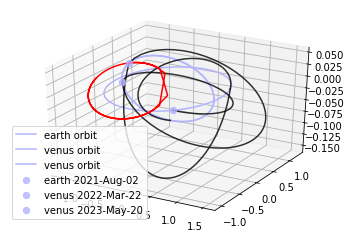

In [12]:
# Plot best result
solar_orbiter.plot(pop.champion_x)

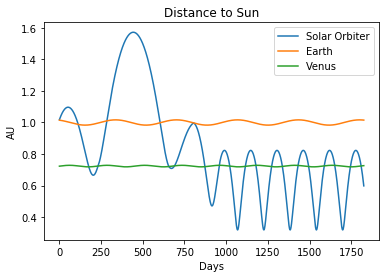

In [13]:
# Plot solar distance in AE
timeframe = range(1,5*365)
earth = jpl_lp("earth")
venus = jpl_lp("venus")

distances = []
edistances = []
vdistances = []

for i in timeframe:
    epoch = pop.champion_x[0]+i
    pos, vel = solar_orbiter.eph(pop.champion_x, epoch)
    epos, evel = earth.eph(epoch)
    vpos, vvel = venus.eph(epoch)
    distances.append(norm(pos) / AU)
    edistances.append(norm(epos) / AU)
    vdistances.append(norm(vpos) / AU)

fig, ax = plt.subplots()
ax.plot(list(timeframe), distances, label="Solar Orbiter")
ax.plot(list(timeframe), edistances, label="Earth")
ax.plot(list(timeframe), vdistances, label="Venus")
ax.set_xlabel("Days")
ax.set_ylabel("AU")
ax.set_title("Distance to Sun")
ax.legend()

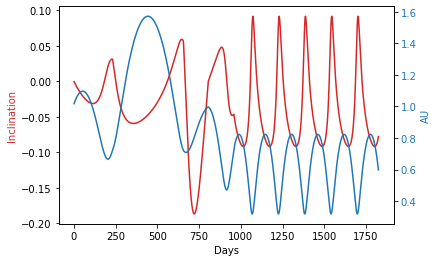

In [14]:
# Plot inclination and distance
inclinations = []
for i in timeframe:
    epoch = pop.champion_x[0]+i
    pos, _ = solar_orbiter.eph(pop.champion_x, epoch)
    inclination = sign(pos[2])*acos(norm(pos[:2]) / norm(pos))
    inclinations.append(inclination)

color = 'tab:red'
fig2, ax2 = plt.subplots()
ax2.plot(list(timeframe), inclinations, color=color)
ax2.set_ylabel("Inclination", color=color)
ax2.set_xlabel("Days")
ax.set_title("Distance and Inclination")

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.set_ylabel('AU', color=color)
ax3.plot(list(timeframe), distances, color=color)
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()